# Clustering

## 0. Libraries, data import and cleaning

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
import gmaps 
import gmaps.datasets
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import Perceptron
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from scipy.stats import boxcox
pd.options.display.max_rows = 50
pd.options.display.max_columns = 999
sns.set_theme()

In [2]:
def clean_data(df):
    df=df.drop(columns=['id','date'])
    df = df[df["bedrooms"] <= 8]
    df = df[(df["bathrooms"] < 6) & (df["bathrooms"] >= 1)]
    df = df[df["sqft_living"] <= 6000]
    df = df[df["sqft_lot"] <= 30000]
    df = df[df["sqft_lot15"] <= 30000]
    df.loc[df["view"] != 0, "view"] = 1
    df = df[df["condition"] > 2]
    df.loc[df["sqft_basement"] != 0, "sqft_basement"] = 1
    df.loc[(df["yr_renovated"]!=0)&(df["yr_renovated"]<2000), "yr_renovated"] = 1
    df.loc[df["yr_renovated"]>=2000, "yr_renovated"] = 2
    
    return df

In [3]:
#Data import and cleaning
path = r"..\Data_Midterm.xls"
rs = pd.read_excel(path, engine="xlrd")
rs = clean_data(rs)

## 1. Creating the dataset and applying the model

The K-means model is a clustering system that automatically creates "centers" where it detects there is a concentration of points. In our case, the centers will be composed of a location (latitude and longitude) and a price.

In [4]:
help(KMeans)

Help on class KMeans in module sklearn.cluster._kmeans:

class KMeans(sklearn.base.TransformerMixin, sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='deprecated', verbose=0, random_state=None, copy_x=True, n_jobs='deprecated', algorithm='auto')
 |  
 |  K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
 |      Method for initialization:
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up convergence. See section
 |      Notes in k_init for more details.
 |  
 |      'random': choose `n_clusters` o

Here we apply the KMeans model, with 2000 centers (10% of the dataset)

In [5]:
location = rs[["lat", "long", "price"]]
X_train, X_test = train_test_split(location)

reg = KMeans(n_clusters=200)

reg.fit(location)



KMeans(n_clusters=200)

## 2. Visualising the results

The centers of the different clusters are "points" with a longitude value, a latitude value, and an "average" price. We will visualise where the houses have been sold, and were the model calculates the centers.

In [6]:
#We prepare the data about the clusters that we obtained. We have three lists with lat, long and price data of the clusters,
#and a dataframe with the same values.
long = []
lat = []
price = []
for index, center in enumerate(reg.cluster_centers_):
    lat.append(center[0])
    long.append(center[1])
    price.append(center[2])
    

centers_df = pd.DataFrame(data={"lat": lat, "long":long, "price":price})



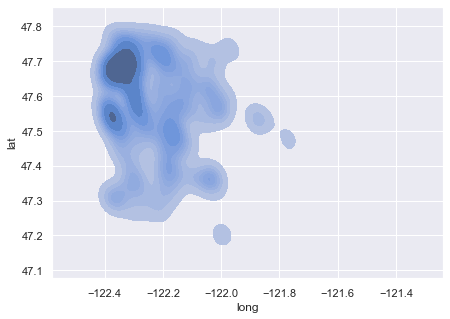

In [7]:
#This is a contour map of the location of the houses sold, with a shade to reflect the number of houses per region
fig, ax = plt.subplots()
fig.set_size_inches(7, 5)


sns.kdeplot(x=location["long"],y=location["lat"], shade="True")
plt.show()

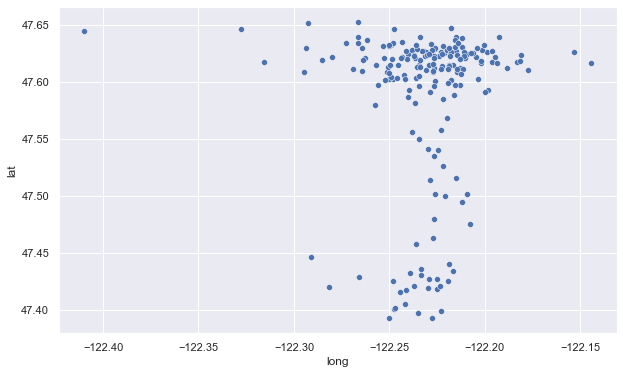

In [8]:
#These are the calculated centers for the different clusters
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

sns.scatterplot(x=centers_df["long"], y=centers_df["lat"])
plt.show()

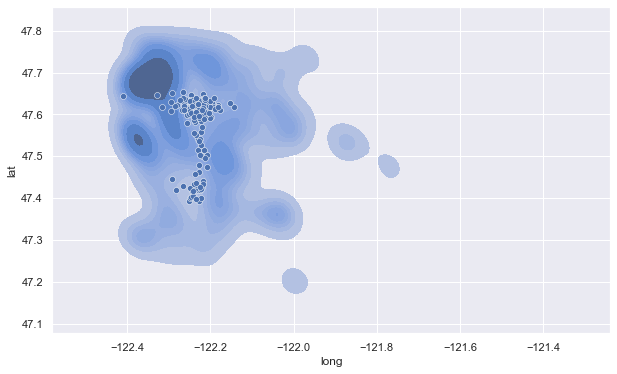

In [9]:
#This is a shaded contour map of the houses sold, so it somehow reflects the density. We superpose the calculated centers.
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

sns.kdeplot(x=location["long"],y=location["lat"], shade="True")
sns.scatterplot(x=centers_df["long"], y=centers_df["lat"])
#sns.kdeplot(x=centers_df["long"],y=centers_df["lat"], shade="True")
plt.show()

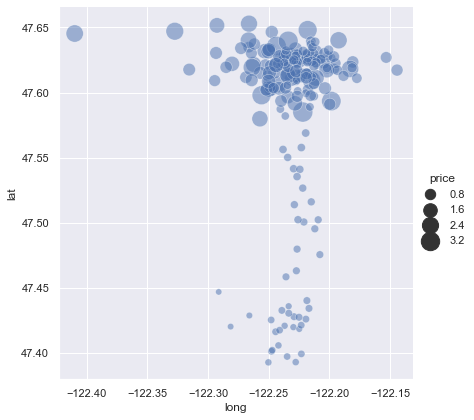

In [10]:
#This is a heatmap that relates the centers with the price (size) of the center calculated value


# Draw a heatmap with the numeric values in each cell
sns.relplot(x="long", y="lat", size="price",
            sizes=(40, 400), alpha=.5,
            height=6, data=centers_df)

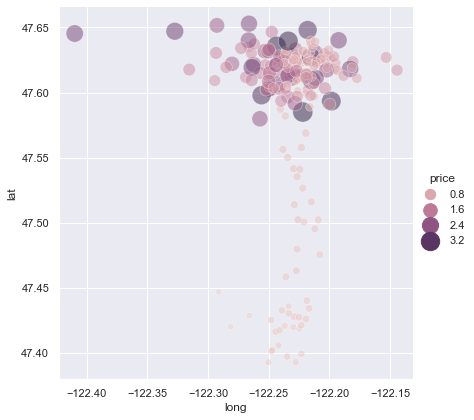

In [11]:
#This is a heatmap that relates the centers with the price (color) of the center calculated value


# Draw a heatmap with the numeric values in each cell
sns.relplot(x="long", y="lat", size="price", hue="price",
            sizes=(40, 400), alpha=.5,
            height=6, data=centers_df)

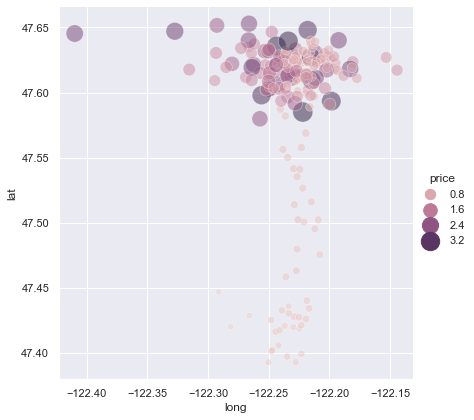

In [12]:
#This is a heatmap that relates the centers with the price (size and color) of the center calculated value


# Draw a heatmap with the numeric values in each cell
sns.relplot(x="long", y="lat", size="price", hue="price",
            sizes=(40, 400), alpha=.5,
            height=6, data=centers_df)

### In these plots we can see how the clusters are related to an average price of the houses that have been sold nearby. We will use this to calculate, in the modeling part, a new column called `location_factor`.



## 3. Visualising on a map with gmaps

We want to visualise the heatmap on top of a real map, so we can see if it makes sense (expensive houses sold in expenseive neighborhoods

In [13]:
with open(r"C:\Users\carlo\OneDrive\Programming\gmaps_api.txt", "r") as f:
    gmaps_api = f.readline()

gmaps.configure(api_key=gmaps_api)    

In [14]:
geoloc_houses = location[['lat', 'long']] 

weights_houses = location["price"]

fig = gmaps.figure()

heatmap_layer = gmaps.heatmap_layer(geoloc_houses, weights=weights_houses) 
fig.add_layer(gmaps.heatmap_layer(geoloc_houses, weights=weights_houses)) 
#symbols = gmaps.symbol_layer(geoloc_houses, fill_color='blue', stroke_color='blue')
#fig.add_layer(symbols)

fig

Figure(layout=FigureLayout(height='420px'))

In [17]:
geoloc_centers = centers_df[['lat', 'long']]
weights_centers = centers_df["price"]

fig = gmaps.figure()

heatmap_layer = gmaps.heatmap_layer(geoloc_houses, weights=weights_houses) 
fig.add_layer(gmaps.heatmap_layer(geoloc_houses, weights=weights_houses)) 
symbols = gmaps.symbol_layer(geoloc_centers, fill_color='blue', stroke_color='green')
fig.add_layer(symbols)

fig

Figure(layout=FigureLayout(height='420px'))